In [199]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.cross_validation import cross_val_score


In [200]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final=pd.read_sql_query(""" SELECT * FROM Reviews  """, conn) 

In [201]:
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
# Sorting data based on time
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final= final.sort_values(by = "Time")

In [202]:
from sklearn.model_selection import train_test_split
X = final["CleanedText"]
y = final["Score"].map(lambda x: 1 if x == 'positive' else 0)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle='false')
print(X_train.shape, Y_train.shape, X_test.shape)

(61442,) (61442,) (26333,)


In [203]:
count_vect = CountVectorizer() 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)


In [204]:
from sklearn.model_selection import TimeSeriesSplit
# Importing libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

base_learners = [25,40,60,80,100,120,200,300]
Depths = [1,3,5,9,11,13,15,24]
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {'n_estimators': base_learners, 'max_depth':Depths}
RFC = RandomForestClassifier()
model = GridSearchCV(RFC, param_grid, scoring = 'roc_auc', cv=tscv , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Auc score of the model : ",model.score(X_test_vec, Y_test))

# Cross-Validation errors
cv_errors = [1-i for i in model.cv_results_['mean_test_score']]

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)
# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of depth is : ",optimal_depth)

# RandomForestClassifier with Optimal number of base learners
rf = RandomForestClassifier(n_estimators=optimal_learners,max_depth=optimal_depth, max_features='sqrt', n_jobs=-1,class_weight="balanced")
rf.fit(X_train_vec,Y_train)
predictions = rf.predict(X_test_vec)
predictions1 = rf.predict(X_train_vec)

# Variables that will be used for  making table in Conclusion part of this assignment
bow_rf_learners = optimal_learners
bow_rf_train_acc = model.score(X_test_vec, Y_test)*100
bow_rf_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=24, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Auc score of the model :  0.8999038808404559
The optimal number of base learners is :  300

The optimal value of depth is :  24


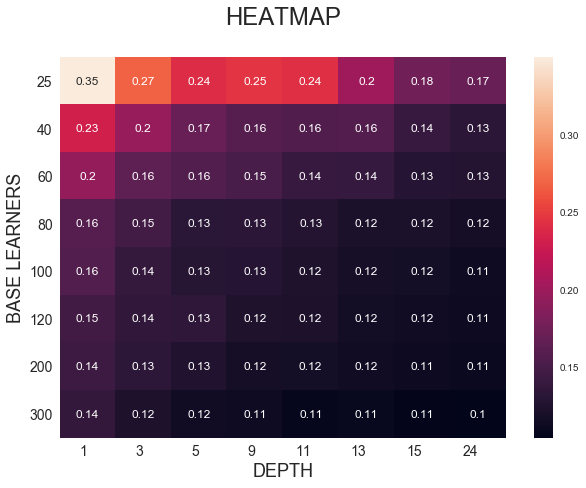

In [205]:
data=np.reshape(cv_errors, (8, 8))


fig = plt.figure(figsize=(10,7))

heatmap = sns.heatmap(data, annot=True)

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(base_learners, rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(Depths, rotation=0, ha='right', fontsize=14)
plt.ylabel('BASE LEARNERS',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("HEATMAP\n",size=24)
plt.show()

In [206]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the RandomForestClassifier for base_learners = %d is %f%%' % (optimal_learners, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))


The Test Accuracy of the RandomForestClassifier for base_learners = 300 is 89.735313%

The Test Precision of the RandomForestClassifier for base_learners = 300 is 0.940207

The Test Recall of the RandomForestClassifier for base_learners = 300 is 0.937010

The Test F1-Score of the RandomForestClassifier for base_learners = 300 is 0.938606


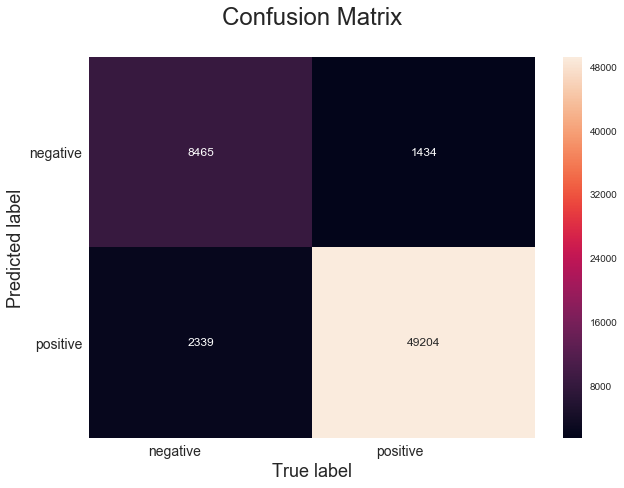

In [207]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, predictions1), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()



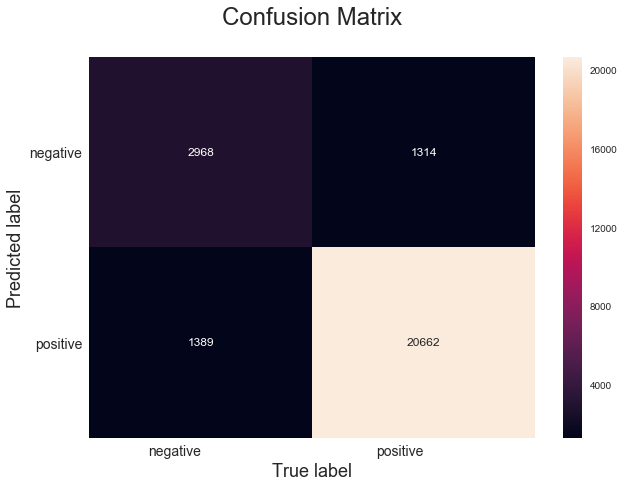

In [208]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()



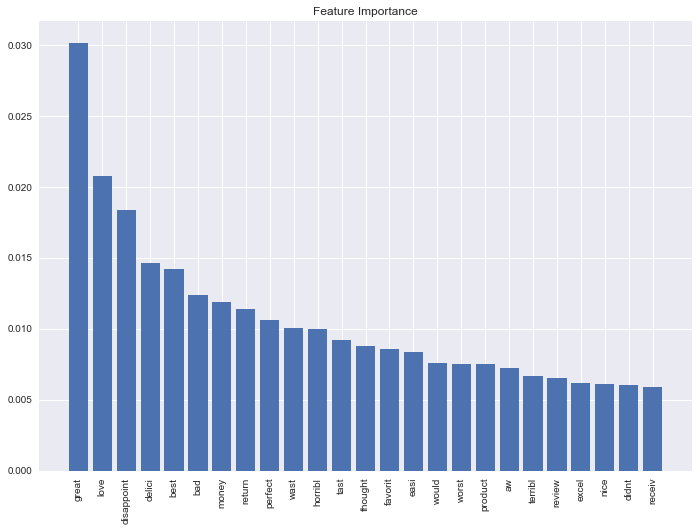

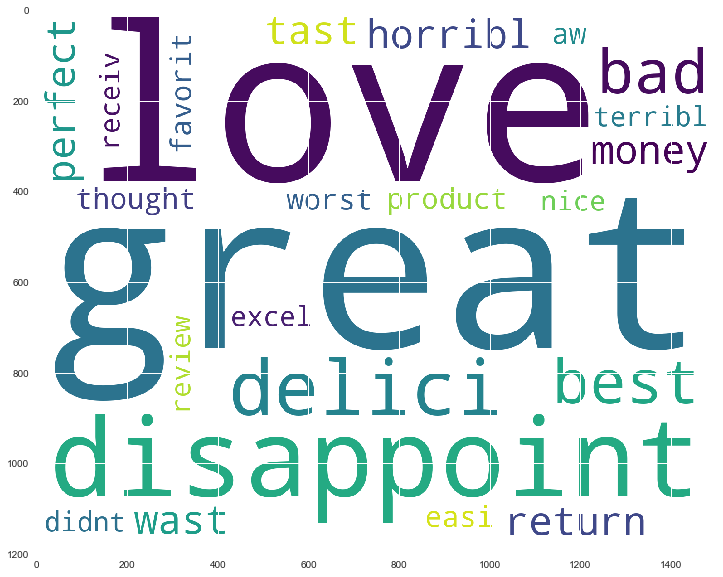

In [209]:
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')
from wordcloud import WordCloud

# Calculate feature importances from decision trees
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]

# Rearrange feature names so they match the sorted feature importances
names = count_vect.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names()

wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(names[indices]))
plt.figure(figsize=(20,10))
plt.imshow(wc)


In [210]:
from sklearn.ensemble import GradientBoostingClassifier

base_learners = [25,40,60,80,100,120,200,300]
Depths = [1,3,5,9,11,13,15,24]
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {'n_estimators': base_learners, 'max_depth':Depths}
GBC = GradientBoostingClassifier(max_features='sqrt',subsample=0.1)
model = GridSearchCV(GBC, param_grid, scoring = 'roc_auc', cv=tscv , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Auc score of the model : ",model.score(X_test_vec, Y_test))

# Cross-Validation errors
cv_errors = np.array([1-i for i in model.cv_results_['mean_test_score']])

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of depth is : ",optimal_depth)


cv_errors

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=13,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=0.1, verbose=0,
              warm_start=False)
Auc score of the model :  0.9099419563467485
The optimal number of base learners is :  300

The optimal value of depth is :  13


array([0.35856328, 0.30731623, 0.25635108, 0.24662037, 0.23332296,
       0.24931625, 0.19649579, 0.16218122, 0.24057527, 0.22897717,
       0.20880604, 0.17604597, 0.16605362, 0.15230478, 0.13328612,
       0.12049786, 0.23558876, 0.18649328, 0.17566632, 0.15753185,
       0.13025211, 0.12718189, 0.11438554, 0.10568149, 0.19961917,
       0.16406351, 0.142852  , 0.13285358, 0.12605689, 0.11749845,
       0.11325384, 0.10689951, 0.19224043, 0.15804687, 0.14088772,
       0.12963278, 0.11940249, 0.12027536, 0.11130515, 0.10957899,
       0.18165429, 0.16065502, 0.13957918, 0.12889501, 0.12447802,
       0.11479194, 0.11117236, 0.10404344, 0.17198192, 0.15113801,
       0.13708071, 0.13034225, 0.12196292, 0.1170665 , 0.1080645 ,
       0.10947404, 0.16664542, 0.15187525, 0.13375681, 0.1272339 ,
       0.12055661, 0.11764704, 0.11260213, 0.11037626])

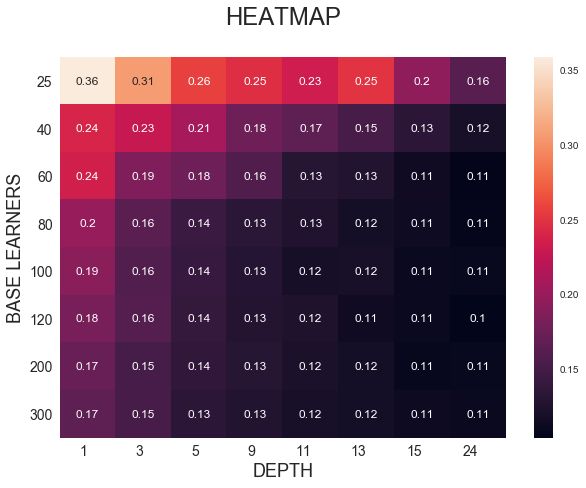

In [211]:
data=np.reshape(cv_errors, (8, 8))


fig = plt.figure(figsize=(10,7))

heatmap = sns.heatmap(data, annot=True)

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(base_learners, rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(Depths, rotation=0, ha='right', fontsize=14)
plt.ylabel('BASE LEARNERS',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("HEATMAP\n",size=24)
plt.show()

In [212]:
# GradientBoostingClassifier with Optimal number of base learners , optimal value of depth and optimal learning rate
gb = GradientBoostingClassifier(n_estimators=optimal_learners, max_depth=optimal_depth, max_features='sqrt', subsample=0.1)
gb.fit(X_train_vec,Y_train)
predictions = gb.predict(X_test_vec)
predictions1 = gb.predict(X_train_vec)

# Variables that will be used for  making table in Conclusion part of this assignment
optimal_rate=0.1
bow_gbdt_learners = optimal_learners
bow_gbdt_depth = optimal_depth
bow_gbdt_train_acc = model.score(X_test_vec, Y_test)*100
bow_gbdt_test_acc = accuracy_score(Y_test, predictions) * 100

# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nTest Accuracy of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f%%' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nTest Precision of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nTest Recall of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nTest F1-Score of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))


Test Accuracy of the GradientBoostingClassifier for base_learners = 300 , depth = 13 and learning_rate = 0.100 is 88.983405%

Test Precision of the GradientBoostingClassifier for base_learners = 300 , depth = 13 and learning_rate = 0.100 is 0.899791

Test Recall of the GradientBoostingClassifier for base_learners = 300 , depth = 13 and learning_rate = 0.100 is 0.977280

Test F1-Score of the GradientBoostingClassifier for base_learners = 300 , depth = 13 and learning_rate = 0.100 is 0.936936


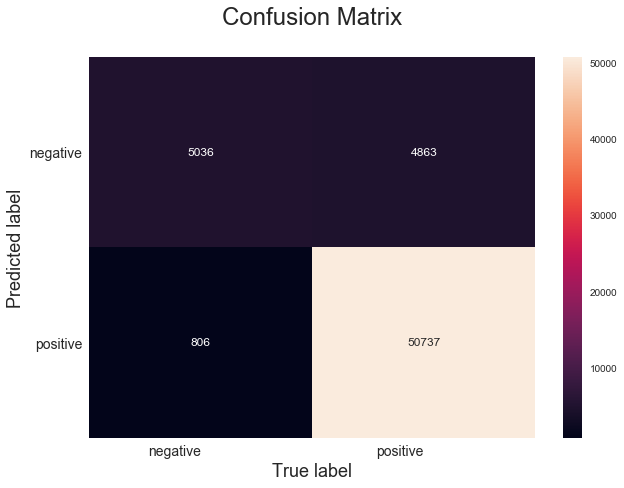

In [213]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, predictions1), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

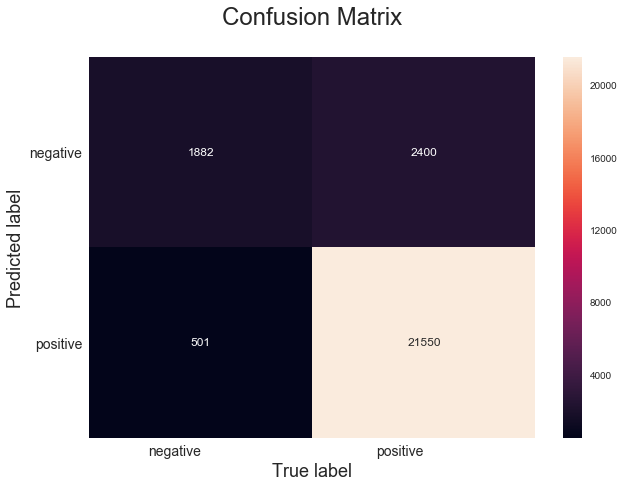

In [214]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

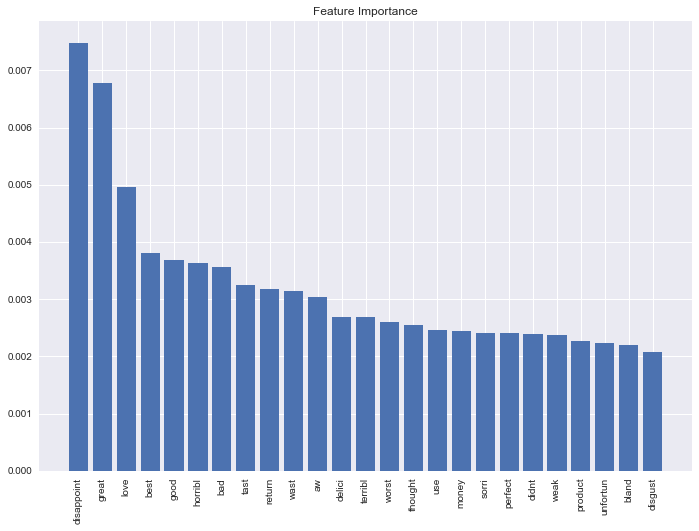

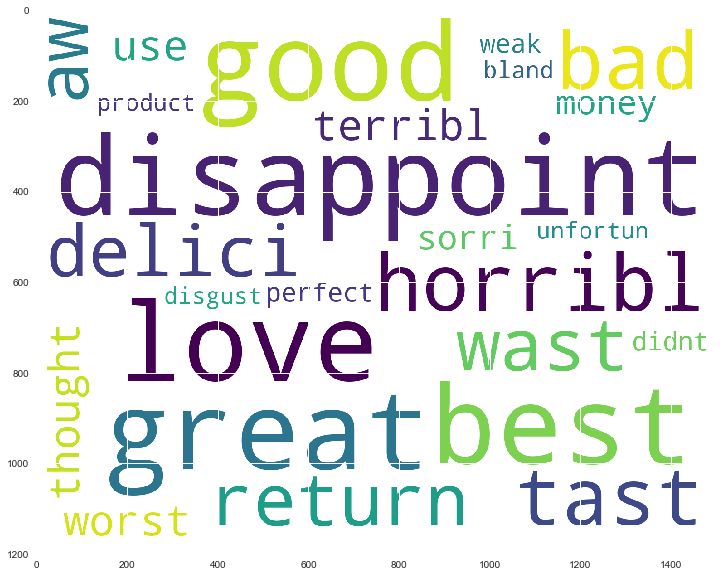

In [215]:
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')
from wordcloud import WordCloud

# Calculate feature importances from decision trees
importances = gb.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]

# Rearrange feature names so they match the sorted feature importances
names = count_vect.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names()

wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(names[indices]))
plt.figure(figsize=(20,10))
plt.imshow(wc)



In [216]:
tf_idf_vect = TfidfVectorizer()
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)

In [217]:
base_learners = [25,40,60,80,100,120,200,300]
Depths = [1,3,5,9,11,13,15,24]
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {'n_estimators': base_learners,'max_depth':Depths}
RFC = RandomForestClassifier(max_features='sqrt')
model = GridSearchCV(RFC, param_grid, scoring = 'roc_auc', cv=tscv , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Auc score of the model : ",model.score(X_test_vec, Y_test))

# Cross-Validation errors
cv_errors = [1-i for i in model.cv_results_['mean_test_score']]

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of depth is : ",optimal_depth)

# RandomForestClassifier with Optimal number of base learners
rf = RandomForestClassifier(n_estimators=optimal_learners,max_depth=optimal_depth, max_features='sqrt', n_jobs=-1,class_weight="balanced")
rf.fit(X_train_vec,Y_train)
predictions = rf.predict(X_test_vec)
prediction1 = rf.predict(X_train_vec)
# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_rf_learners = optimal_learners
tfidf_rf_train_acc = model.score(X_test_vec, Y_test)*100
tfidf_rf_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=24, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Auc score of the model :  0.9049073714323368
The optimal number of base learners is :  300

The optimal value of depth is :  24


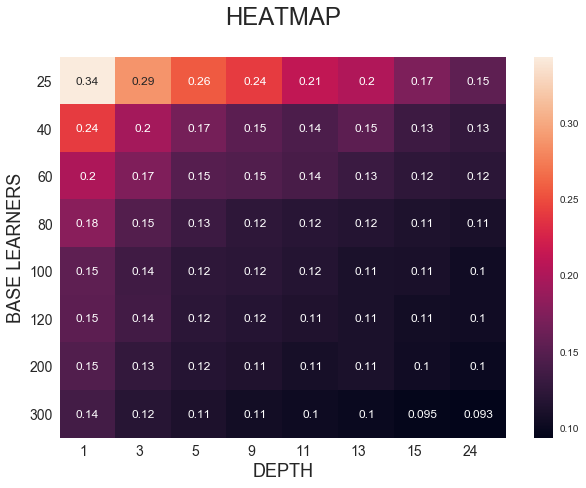

In [218]:
data=np.reshape(cv_errors, (8, 8))


fig = plt.figure(figsize=(10,7))

heatmap = sns.heatmap(data, annot=True)

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(base_learners, rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(Depths, rotation=0, ha='right', fontsize=14)
plt.ylabel('BASE LEARNERS',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("HEATMAP\n",size=24)
plt.show()

In [219]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the RandomForestClassifier for base_learners = %d is %f%%' % (optimal_learners, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))


The Test Accuracy of the RandomForestClassifier for base_learners = 300 is 89.670755%

The Test Precision of the RandomForestClassifier for base_learners = 300 is 0.940121

The Test Recall of the RandomForestClassifier for base_learners = 300 is 0.936284

The Test F1-Score of the RandomForestClassifier for base_learners = 300 is 0.938199


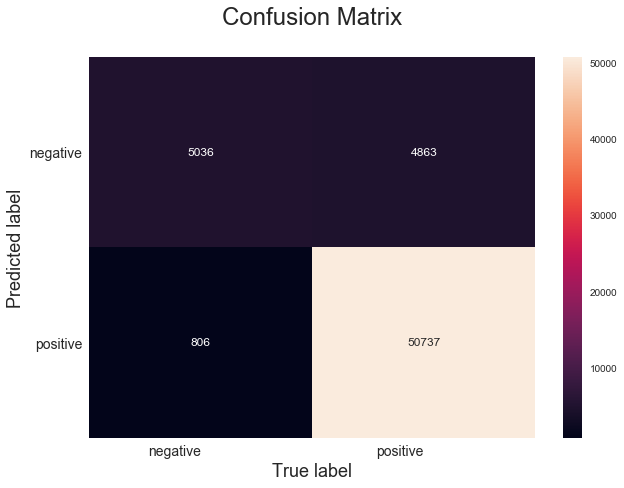

In [220]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, predictions1), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

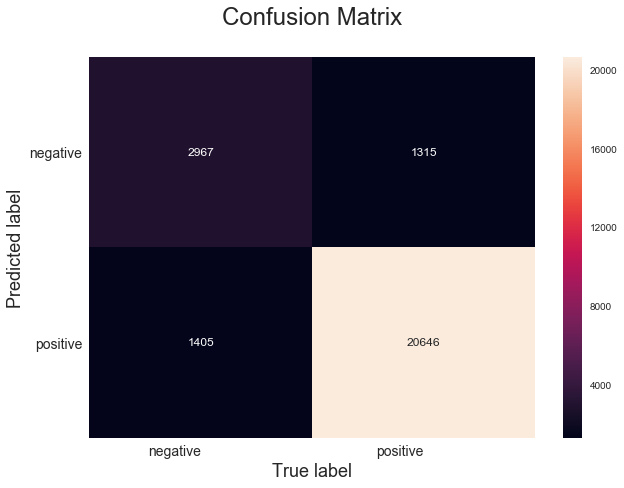

In [221]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()



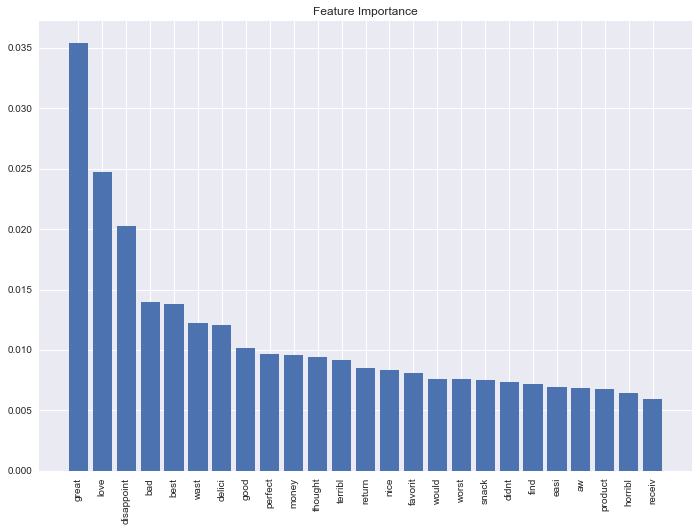

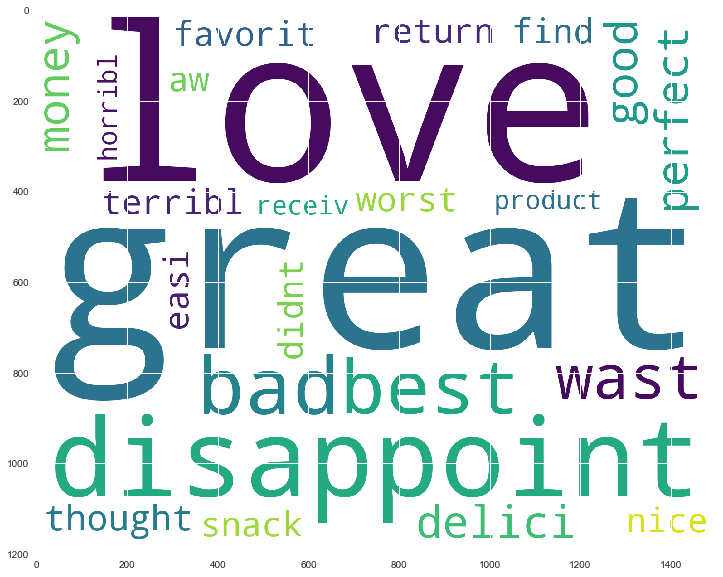

In [222]:
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')
from wordcloud import WordCloud

# Calculate feature importances from decision trees
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]

# Rearrange feature names so they match the sorted feature importances
names = tf_idf_vect.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names()

wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(names[indices]))
plt.figure(figsize=(20,10))
plt.imshow(wc)


In [223]:
from sklearn.ensemble import GradientBoostingClassifier

base_learners = [25,40,60,80,100,120,200,300]
Depths = [1,3,5,9,11,13,15,24]
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {'n_estimators': base_learners, 'max_depth':Depths}
GBC = GradientBoostingClassifier(max_features='sqrt',subsample=0.1)
model = GridSearchCV(GBC, param_grid, scoring = 'roc_auc', cv=tscv , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Auc score of the model : ",model.score(X_test_vec, Y_test))

# Cross-Validation errors
cv_errors = np.array([1-i for i in model.cv_results_['mean_test_score']])

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# Optimal value of depth
max_depth=optimal_depth
# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of depth is : ",optimal_depth)

print("\nThe optimal value of learning rate is : ",optimal_rate)
cv_errors

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=0.1, verbose=0,
              warm_start=False)
Auc score of the model :  0.9115712628389316
The optimal number of base learners is :  300

The optimal value of depth is :  9

The optimal value of learning rate is :  0.1


array([0.33968947, 0.33198483, 0.28058789, 0.26293663, 0.2316851 ,
       0.23237287, 0.18163451, 0.15364314, 0.27285778, 0.23509541,
       0.19766453, 0.17988747, 0.16072239, 0.16084871, 0.13547309,
       0.12151833, 0.24170775, 0.19746724, 0.16733153, 0.15799797,
       0.1510555 , 0.14261509, 0.12113911, 0.11436717, 0.19016589,
       0.17013769, 0.15310142, 0.14112579, 0.13191423, 0.12451133,
       0.11869027, 0.10961426, 0.19004681, 0.16385425, 0.1498493 ,
       0.13817324, 0.13399767, 0.12601199, 0.12066026, 0.11393761,
       0.18119731, 0.16427496, 0.14981411, 0.13785598, 0.13607732,
       0.12686728, 0.12191258, 0.11600115, 0.19072966, 0.16319286,
       0.14730932, 0.13817949, 0.12778259, 0.12396507, 0.1215985 ,
       0.11225032, 0.17550943, 0.16154136, 0.14810543, 0.1355326 ,
       0.1312959 , 0.12761123, 0.12360768, 0.12767966])

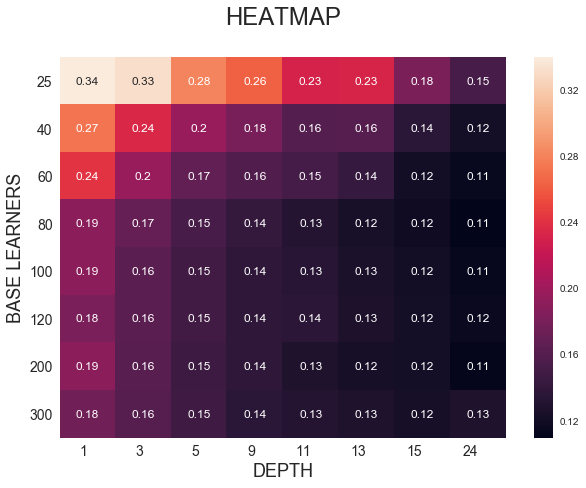

In [224]:
data=np.reshape(cv_errors, (8, 8))


fig = plt.figure(figsize=(10,7))

heatmap = sns.heatmap(data, annot=True)

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(base_learners, rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(Depths, rotation=0, ha='right', fontsize=14)
plt.ylabel('BASE LEARNERS',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("HEATMAP\n",size=24)
plt.show()

In [225]:
# GradientBoostingClassifier with Optimal number of base learners , optimal value of depth and optimal learning rate
gb = GradientBoostingClassifier(n_estimators=optimal_learners, max_depth=optimal_depth, max_features='sqrt', subsample=0.1)
gb.fit(X_train_vec,Y_train)
predictions = gb.predict(X_test_vec)
predictions1 = gb.predict(X_train_vec)
# Variables that will be used for  making table in Conclusion part of this assignment

tfidf_gbdt_learners = optimal_learners
tfidf_gbdt_depth = optimal_depth
tfidf_gbdt_train_acc = model.score(X_test_vec, Y_test)*100
tfidf_gbdt_test_acc = accuracy_score(Y_test, predictions) * 100
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nTest Accuracy of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f%%' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nTest Precision of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nTest Recall of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nTest F1-Score of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))


Test Accuracy of the GradientBoostingClassifier for base_learners = 300 , depth = 9 and learning_rate = 0.100 is 88.899859%

Test Precision of the GradientBoostingClassifier for base_learners = 300 , depth = 9 and learning_rate = 0.100 is 0.897242

Test Recall of the GradientBoostingClassifier for base_learners = 300 , depth = 9 and learning_rate = 0.100 is 0.979638

Test F1-Score of the GradientBoostingClassifier for base_learners = 300 , depth = 9 and learning_rate = 0.100 is 0.936631


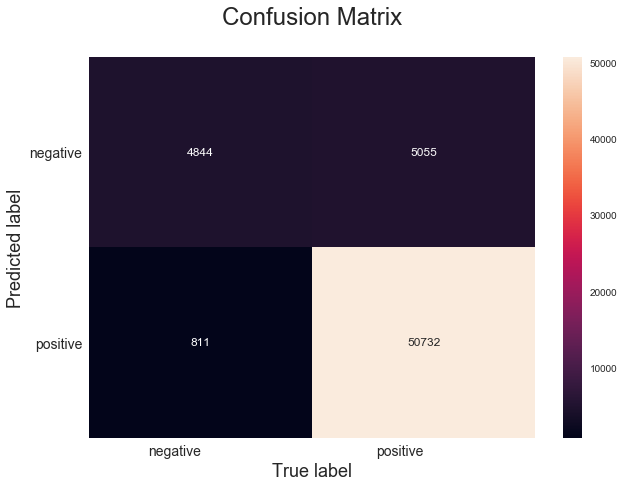

In [226]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, predictions1), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

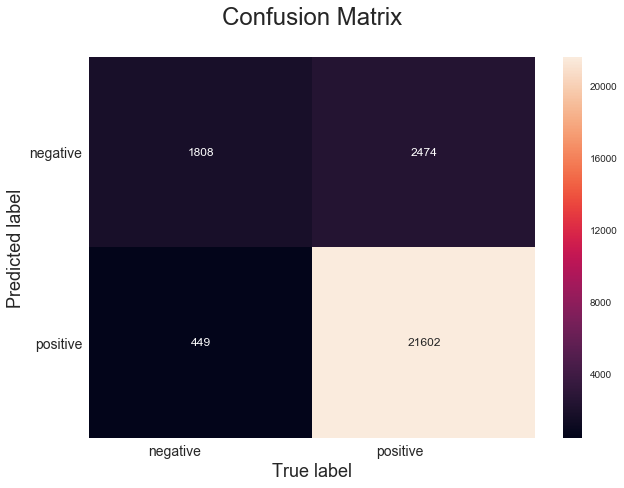

In [227]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

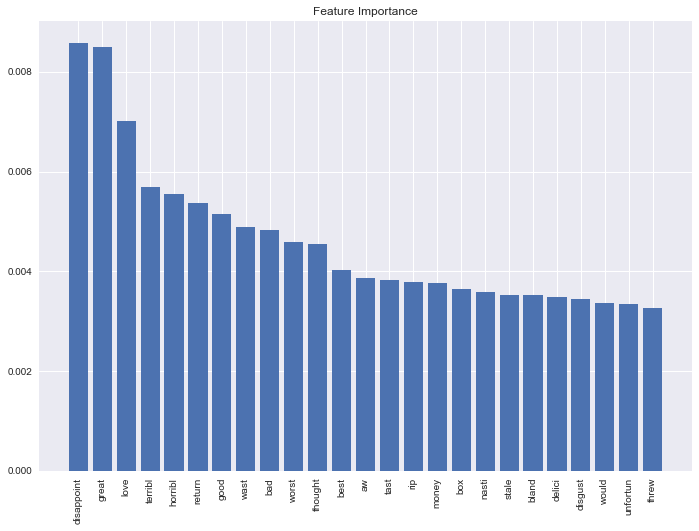

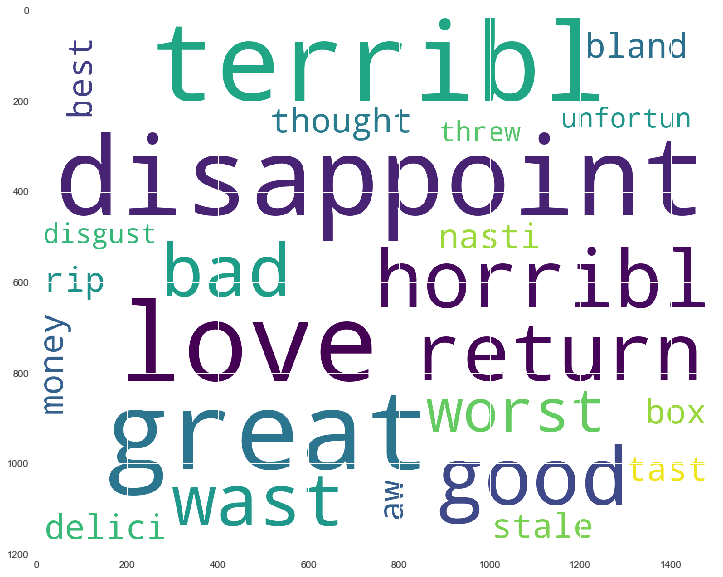

In [228]:
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')
from wordcloud import WordCloud

# Calculate feature importances from decision trees
importances = gb.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]

# Rearrange feature names so they match the sorted feature importances
names = tf_idf_vect.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names()

wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(names[indices]))
plt.figure(figsize=(20,10))
plt.imshow(wc)


In [229]:
from sklearn.model_selection import train_test_split
X = final["Text"]
y = final["Score"].map(lambda x: 1 if x == 'positive' else 0)
X_train, x_test, y_train, y_test =train_test_split(X, y.values, test_size = 0.3, shuffle='false')
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(61442,) (26333,) (61442,) (26333,)


In [230]:
list_of_sent=[]
#for sent in final_40k['Text'].values:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
import gensim
list_of_sent_test = []
#for sent in final_40k['Text'].values:
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)    

In [231]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [232]:
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

61442
50
26333
50


In [233]:
X_train = sent_vectors
x_test = sent_vectors_test

In [234]:
base_learners = [25,40,60,80,100,120,200,300]
Depths = [1,3,5,9,11,13,15,24]
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {'n_estimators': base_learners,'max_depth': Depths}
RFC = RandomForestClassifier(max_features='sqrt')
model = GridSearchCV(RFC, param_grid, scoring = 'roc_auc', cv=tscv , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Auc score of the model : ",model.score(X_test_vec, Y_test))

# Cross-Validation errors
cv_errors = [1-i for i in model.cv_results_['mean_test_score']]

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)
# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of depth is : ",optimal_depth)

# RandomForestClassifier with Optimal number of base learners
rf = RandomForestClassifier(n_estimators=optimal_learners,max_depth=optimal_depth, max_features='sqrt', n_jobs=-1,class_weight="balanced")
rf.fit(X_train_vec,Y_train)
predictions = rf.predict(X_test_vec)
predictions1 = rf.predict(X_train_vec)
# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_rf_learners = optimal_learners
avg_w2v_rf_train_acc = model.score(X_test_vec, Y_test)*100
avg_w2v_rf_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=24, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Auc score of the model :  0.9066022926640422
The optimal number of base learners is :  300

The optimal value of depth is :  24


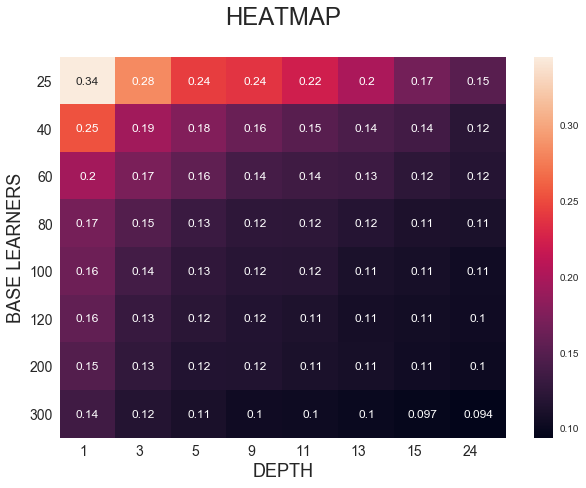

In [235]:
data=np.reshape(cv_errors, (8, 8))


fig = plt.figure(figsize=(10,7))

heatmap = sns.heatmap(data, annot=True)

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(base_learners, rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(Depths, rotation=0, ha='right', fontsize=14)
plt.ylabel('BASE LEARNERS',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("HEATMAP\n",size=24)
plt.show()

In [236]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the RandomForestClassifier for base_learners = %d is %f%%' % (optimal_learners, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))


The Test Accuracy of the RandomForestClassifier for base_learners = 300 is 89.480880%

The Test Precision of the RandomForestClassifier for base_learners = 300 is 0.940105

The Test Recall of the RandomForestClassifier for base_learners = 300 is 0.933881

The Test F1-Score of the RandomForestClassifier for base_learners = 300 is 0.936982


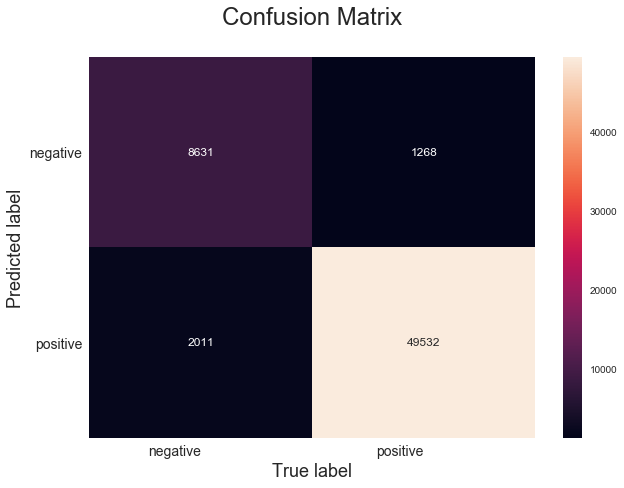

In [237]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, predictions1), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

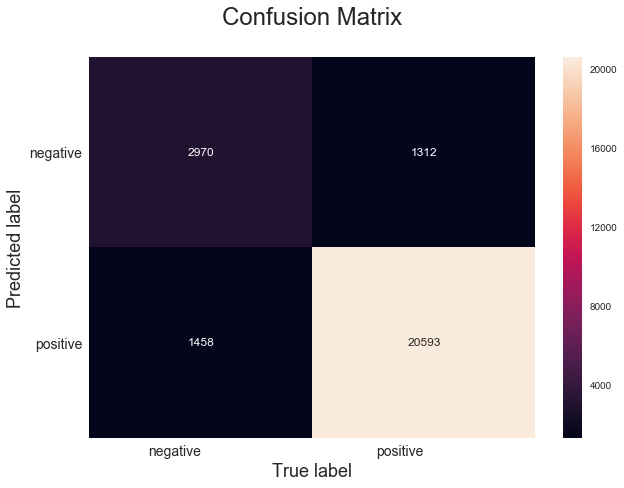

In [238]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()



In [239]:
from sklearn.ensemble import GradientBoostingClassifier

base_learners = [25,40,60,80,100,120,200,300]
Depths = [1,3,5,9,11,13,15,24]
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {'n_estimators': base_learners, 'max_depth':Depths}
GBC = GradientBoostingClassifier(max_features='sqrt',subsample=0.1)
model = GridSearchCV(GBC, param_grid, scoring = 'roc_auc', cv=tscv , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Auc score of the model : ",model.score(X_test_vec, Y_test))

# Cross-Validation errors
cv_errors = np.array([1-i for i in model.cv_results_['mean_test_score']])

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of depth is : ",optimal_depth)

print("\nThe optimal value of learning rate is : ",optimal_rate)
cv_errors

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=0.1, verbose=0,
              warm_start=False)
Auc score of the model :  0.9108406839386873
The optimal number of base learners is :  300

The optimal value of depth is :  9

The optimal value of learning rate is :  0.1


array([0.3713158 , 0.29823229, 0.25995131, 0.24653493, 0.24946859,
       0.22594687, 0.18878025, 0.16266875, 0.26975624, 0.22339421,
       0.19719399, 0.18077737, 0.15977252, 0.16916518, 0.13227685,
       0.12127076, 0.22472547, 0.18447742, 0.17616379, 0.15076717,
       0.15420764, 0.14071008, 0.12291583, 0.11323391, 0.20007613,
       0.17568357, 0.15217689, 0.14046002, 0.13200907, 0.12641796,
       0.11949645, 0.11166653, 0.19653894, 0.16982673, 0.15035816,
       0.13365794, 0.13005164, 0.12384627, 0.11531868, 0.11361003,
       0.19151648, 0.16699095, 0.14355206, 0.13923568, 0.13264568,
       0.12774684, 0.11942519, 0.1186458 , 0.19061252, 0.16098942,
       0.14490627, 0.1377344 , 0.13389539, 0.12342542, 0.12411765,
       0.12479405, 0.18082064, 0.15942449, 0.14283385, 0.14563387,
       0.13066152, 0.13047658, 0.12090464, 0.11441206])

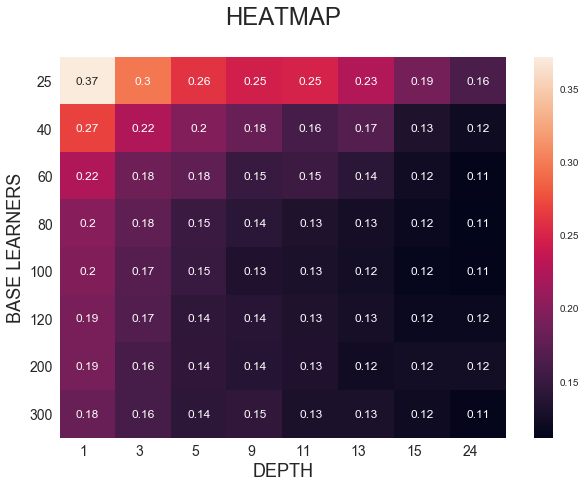

In [240]:
data=np.reshape(cv_errors, (8, 8))


fig = plt.figure(figsize=(10,7))

heatmap = sns.heatmap(data, annot=True)

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(base_learners, rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(Depths, rotation=0, ha='right', fontsize=14)
plt.ylabel('BASE LEARNERS',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("HEATMAP\n",size=24)
plt.show()

In [241]:
# GradientBoostingClassifier with Optimal number of base learners , optimal value of depth and optimal learning rate
gb = GradientBoostingClassifier(n_estimators=optimal_learners, max_depth=optimal_depth, max_features='sqrt', subsample=0.1)
gb.fit(X_train_vec,Y_train)
predictions = gb.predict(X_test_vec)
predictions1 = gb.predict(X_train_vec)
# Variables that will be used for  making table in Conclusion part of this assignment

avg_w2v_gbdt_learners = optimal_learners
avg_w2v_gbdt_depth = optimal_depth
avg_w2v_gbdt_train_acc = model.score(X_test_vec, Y_test)*100
avg_w2v_gbdt_test_acc = accuracy_score(Y_test, predictions) * 100



# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nTest Accuracy of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f%%' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nTest Precision of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nTest Recall of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nTest F1-Score of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))


Test Accuracy of the GradientBoostingClassifier for base_learners = 300 , depth = 9 and learning_rate = 0.100 is 89.070748%

Test Precision of the GradientBoostingClassifier for base_learners = 300 , depth = 9 and learning_rate = 0.100 is 0.898823

Test Recall of the GradientBoostingClassifier for base_learners = 300 , depth = 9 and learning_rate = 0.100 is 0.979774

Test F1-Score of the GradientBoostingClassifier for base_learners = 300 , depth = 9 and learning_rate = 0.100 is 0.937554


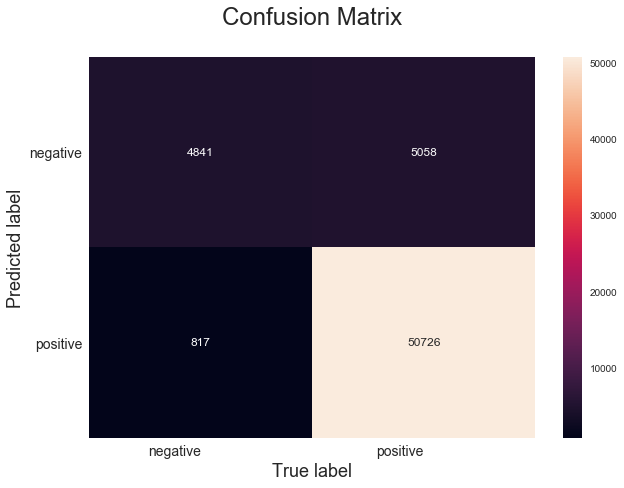

In [242]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, predictions1), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

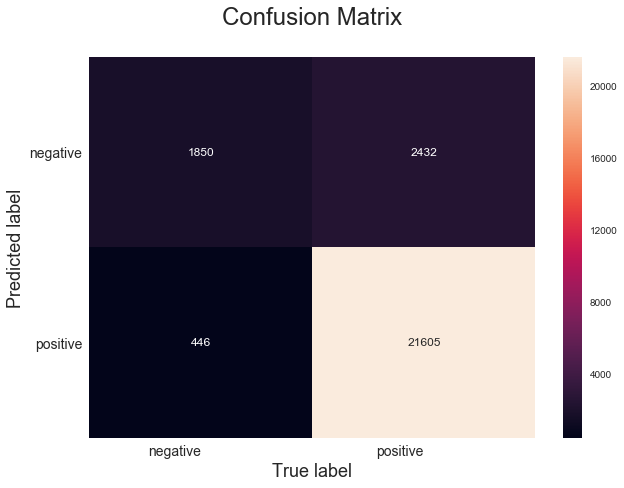

In [243]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [244]:
w2v_words = list(w2v_model.wv.vocab)
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1  

In [245]:
X_train = tfidf_sent_vectors

In [246]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1  

In [247]:
x_test = tfidf_sent_vectors_test
X_train = np.nan_to_num(X_train)
x_test = np.nan_to_num(x_test)

In [249]:
base_learners = [25,40,60,80,100,120,200,300]
Depths = [1,3,5,9,11,13,15,24]
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {'n_estimators': base_learners, 'max_depth':Depths}
RFC = RandomForestClassifier(max_features='sqrt')
model = GridSearchCV(RFC, param_grid, scoring = 'roc_auc', cv=tscv , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Auc score of the model : ",model.score(X_test_vec, Y_test))

# Cross-Validation errors
cv_errors = [1-i for i in model.cv_results_['mean_test_score']]

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)
# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of depth is : ",optimal_depth)

# RandomForestClassifier with Optimal number of base learners
rf = RandomForestClassifier(n_estimators=optimal_learners,max_depth=optimal_depth, max_features='sqrt', n_jobs=-1,class_weight="balanced")
rf.fit(X_train_vec,Y_train)
predictions = rf.predict(X_test_vec)
predictions1 = rf.predict(X_train_vec)
# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_w2v_rf_learners = optimal_learners
tfidf_w2v_rf_train_acc = model.score(X_test_vec, Y_test)*100
tfidf_w2v_rf_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=24, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Auc score of the model :  0.908030290953685
The optimal number of base learners is :  300

The optimal value of depth is :  24


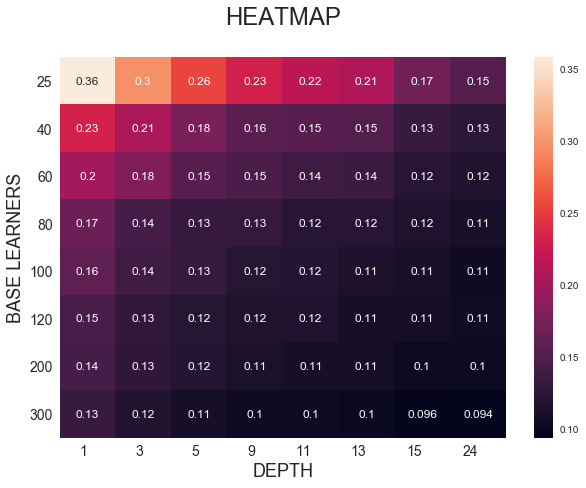

In [250]:
data=np.reshape(cv_errors, (8, 8))


fig = plt.figure(figsize=(10,7))

heatmap = sns.heatmap(data, annot=True)

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(base_learners, rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(Depths, rotation=0, ha='right', fontsize=14)
plt.ylabel('BASE LEARNERS',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("HEATMAP\n",size=24)
plt.show()

In [251]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the RandomForestClassifier for base_learners = %d is %f%%' % (optimal_learners, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the RandomForestClassifier for base_learners = %d is %f' % (optimal_learners, acc))


The Test Accuracy of the RandomForestClassifier for base_learners = 300 is 89.636578%

The Test Precision of the RandomForestClassifier for base_learners = 300 is 0.938897

The Test Recall of the RandomForestClassifier for base_learners = 300 is 0.937236

The Test F1-Score of the RandomForestClassifier for base_learners = 300 is 0.938066


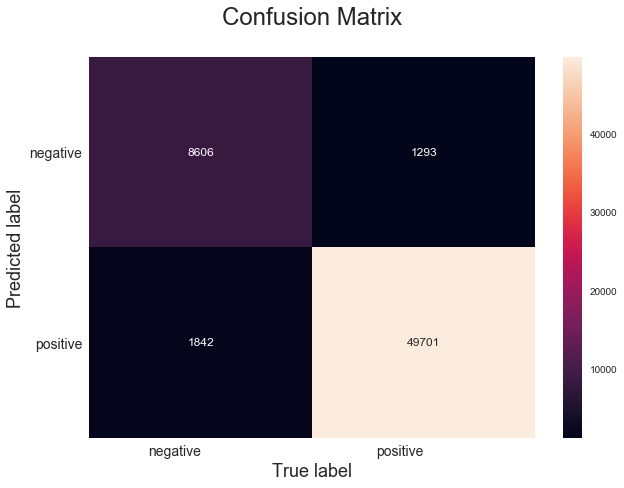

In [252]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, predictions1), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

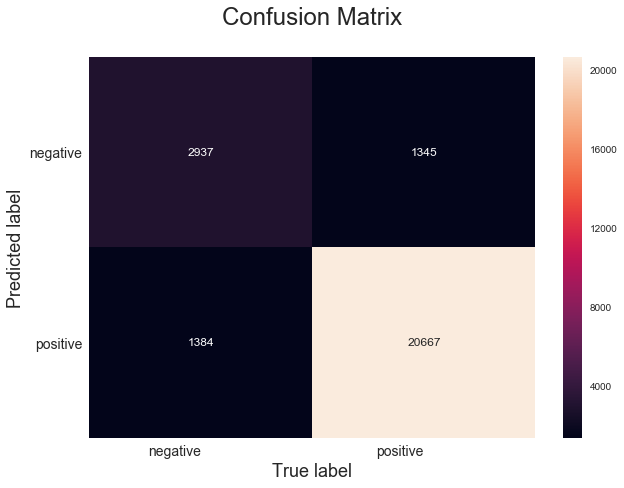

In [253]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()



In [254]:
from sklearn.ensemble import GradientBoostingClassifier

base_learners = [25,40,60,80,100,120,200,300]
Depths = [1,3,5,9,11,13,15,24]
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {'n_estimators': base_learners, 'max_depth':Depths}
GBC = GradientBoostingClassifier(max_features='sqrt',subsample=0.1)
model = GridSearchCV(GBC, param_grid, scoring = 'roc_auc', cv=tscv , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Auc score of the model : ",model.score(X_test_vec, Y_test))

# Cross-Validation errors
cv_errors = np.array([1-i for i in model.cv_results_['mean_test_score']])

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of depth is : ",optimal_depth)

print("\nThe optimal value of learning rate is : ",optimal_rate)
cv_errors

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=0.1, verbose=0,
              warm_start=False)
Auc score of the model :  0.9102582478802536
The optimal number of base learners is :  300

The optimal value of depth is :  5

The optimal value of learning rate is :  0.1


array([0.36418652, 0.35266054, 0.28753218, 0.26428185, 0.24796469,
       0.22705494, 0.18474537, 0.15637237, 0.25836292, 0.2227139 ,
       0.19821787, 0.17266121, 0.16620258, 0.15690712, 0.13254774,
       0.129579  , 0.23129168, 0.18693273, 0.16815457, 0.15712805,
       0.14539133, 0.14277328, 0.1260039 , 0.11063436, 0.20091604,
       0.17348314, 0.15003185, 0.13887071, 0.13621825, 0.12646938,
       0.11713165, 0.11391052, 0.18749584, 0.16472331, 0.15169431,
       0.13721878, 0.13166276, 0.12766496, 0.11737758, 0.11619742,
       0.19013268, 0.16090676, 0.15066805, 0.14022277, 0.13035297,
       0.12608655, 0.11875091, 0.11449151, 0.18709578, 0.1687443 ,
       0.14516331, 0.13392992, 0.13186509, 0.12451535, 0.12142578,
       0.12001859, 0.1761261 , 0.16242841, 0.1457642 , 0.13552302,
       0.13778816, 0.12422859, 0.12025367, 0.11845167])

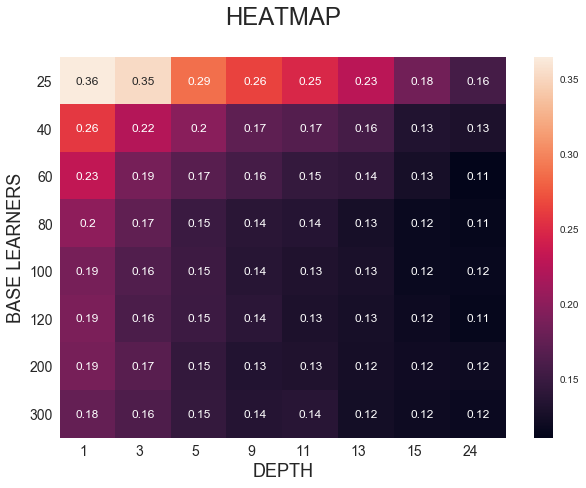

In [255]:
data=np.reshape(cv_errors, (8, 8))


fig = plt.figure(figsize=(10,7))

heatmap = sns.heatmap(data, annot=True)

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(base_learners, rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(Depths, rotation=0, ha='right', fontsize=14)
plt.ylabel('BASE LEARNERS',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("HEATMAP\n",size=24)
plt.show()

In [256]:
# GradientBoostingClassifier with Optimal number of base learners , optimal value of depth and optimal learning rate
gb = GradientBoostingClassifier(n_estimators=optimal_learners, max_depth=optimal_depth, max_features='sqrt', subsample=0.1)
gb.fit(X_train_vec,Y_train)
predictions = gb.predict(X_test_vec)
predictions1 = gb.predict(X_train_vec)
# Variables that will be used for  making table in Conclusion part of this assignment

tfidf_w2v_gbdt_learners = optimal_learners
tfidf_w2v_gbdt_depth = optimal_depth
tfidf_w2v_gbdt_train_acc = model.score(X_test_vec, Y_test)*100
tfidf_w2v_gbdt_test_acc = accuracy_score(Y_test, predictions) * 100


# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nTest Accuracy of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f%%' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nTest Precision of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nTest Recall of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nTest F1-Score of the GradientBoostingClassifier for base_learners = %d , depth = %d and learning_rate = %.3f is %f' % (optimal_learners,optimal_depth,optimal_rate,acc))


Test Accuracy of the GradientBoostingClassifier for base_learners = 300 , depth = 5 and learning_rate = 0.100 is 88.372005%

Test Precision of the GradientBoostingClassifier for base_learners = 300 , depth = 5 and learning_rate = 0.100 is 0.886285

Test Recall of the GradientBoostingClassifier for base_learners = 300 , depth = 5 and learning_rate = 0.100 is 0.987892

Test F1-Score of the GradientBoostingClassifier for base_learners = 300 , depth = 5 and learning_rate = 0.100 is 0.934334


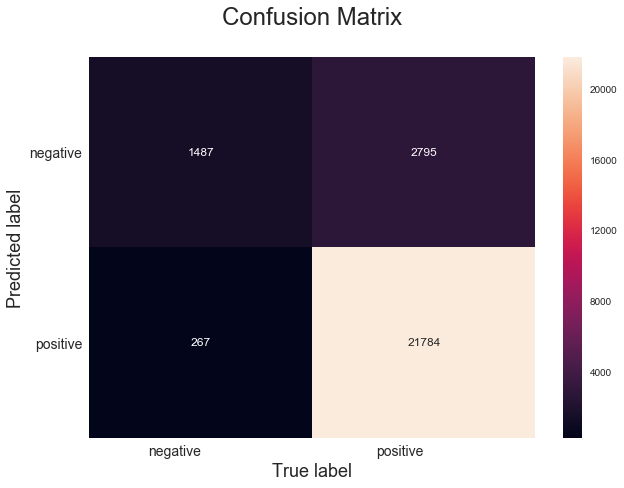

In [257]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [258]:
# Creating table using PrettyTable library
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')
from prettytable import PrettyTable

# Table for Random Forest
names_rf = ['Random Forest for BoW','Random Forest for TFIDF','Random Forest for Avg_Word2Vec',\
            'Random Forest for tfidf_Word2Vec']

learners_rf = [bow_rf_learners,tfidf_rf_learners,avg_w2v_rf_learners,tfidf_w2v_rf_learners]

train_acc_rf = [bow_rf_train_acc,tfidf_rf_train_acc,avg_w2v_rf_train_acc,tfidf_w2v_rf_train_acc]

test_acc_rf = [bow_rf_test_acc,tfidf_rf_test_acc,avg_w2v_rf_test_acc,tfidf_w2v_rf_test_acc]

numbering_rf = [1,2,3,4]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering_rf)
ptable.add_column("MODEL",names_rf)
ptable.add_column("Base Learners ",learners_rf)
ptable.add_column("Training Accuracy",train_acc_rf)
ptable.add_column("Test Accuracy",test_acc_rf)

print('\t\t\t\t\tTABLE FOR RANDOM FOREST')
# Printing the Table
print(ptable)
print("\n\n")




# Table for Gradient Boosting Decision Tree (GBDT)
names = ['GBDT for BoW','GBDT for TFIDF','GBDT for Avg_Word2Vec','GBDT for tfidf_Word2Vec']

base_learners = [bow_gbdt_learners,tfidf_gbdt_learners,avg_w2v_gbdt_learners,tfidf_w2v_gbdt_learners]

optimal_depth = [bow_gbdt_depth,tfidf_gbdt_depth,avg_w2v_gbdt_depth,tfidf_w2v_gbdt_depth]


train_acc = [bow_gbdt_train_acc,tfidf_gbdt_train_acc,avg_w2v_gbdt_train_acc,tfidf_w2v_gbdt_train_acc]

test_acc = [bow_gbdt_test_acc,8896821478752895,avg_w2v_gbdt_test_acc,tfidf_w2v_gbdt_test_acc]

numbering = [1,2,3,4]

# Initializing prettytable
table = PrettyTable()

# Adding columns
table.add_column("S.NO.",numbering)
table.add_column("MODEL",names)
table.add_column("Base Learners ",base_learners)
table.add_column("Optimal_Depth",optimal_depth)
table.add_column("Training Accuracy",train_acc)
table.add_column("Test Accuracy",test_acc)

print('\t\t\t\tTABLE FOR GRADIENT BOOSTING DECISION TREE (GBDT)')
# Printing the Table
print(table)

					TABLE FOR RANDOM FOREST
+-------+----------------------------------+----------------+-------------------+-------------------+
| S.NO. |              MODEL               | Base Learners  | Training Accuracy |   Test Accuracy   |
+-------+----------------------------------+----------------+-------------------+-------------------+
|   1   |      Random Forest for BoW       |      300       | 89.99038808404559 | 89.73531310522918 |
|   2   |     Random Forest for TFIDF      |      300       | 90.49073714323367 | 89.67075532601679 |
|   3   |  Random Forest for Avg_Word2Vec  |      300       | 90.66022926640423 | 89.48087950480385 |
|   4   | Random Forest for tfidf_Word2Vec |      300       |  90.8030290953685 | 89.63657767819846 |
+-------+----------------------------------+----------------+-------------------+-------------------+



				TABLE FOR GRADIENT BOOSTING DECISION TREE (GBDT)
+-------+-------------------------+----------------+---------------+-------------------+-----------